**Goal**

The goal of this notebook is to see how mutual information develops in an online continual learner. We will be using the MNIST dataset, broken down into different tasks.

In [ ]:
#@title Import Modules
import math
import functools

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from collections import Counter
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

In [ ]:
#@title Define Hyperparameters
device        = 'cuda'
lr            = 7e-2
epochs_pre    = 10
epochs_online = 1
milestones    = [epochs_pre//2]
gamma         = 0.5
batch_size    = 1  # batch size is one for OCLs
test_bat_size = 512
momentum      = 0
weight_decay  = 0
n_bins        = 10

In [ ]:
#@title Construct Deep Network
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(12, 10)
        self.fc2 = nn.Linear(10, 7)
        self.fc3 = nn.Linear(7, 5)
        self.fc4 = nn.Linear(5, 4)
        self.fc5 = nn.Linear(4, 3)
        self.fc6 = nn.Linear(3, 10)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = torch.tanh(self.fc4(h3))
        h5 = torch.tanh(self.fc5(h4))
        h6 = F.log_softmax(self.fc6(h5), dim=1)
        return h1, h2, h3, h4, h5, h6

model = Model().to(device)

# loss function
loss_function = nn.NLLLoss()

# optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [ ]:
#@title Load data
# Define data processors
def process_dataset(dataset, digits):
    # keep only images in digits
    conditions = []
    for digit in digits:
      conditions.append((dataset.targets == digit))
    indices = functools.reduce(torch.logical_or, conditions)

    dataset.data, dataset.targets = dataset.data[indices], dataset.targets[indices]

    dataset = TensorDataset(dataset.data.reshape(-1, 28*28), dataset.targets)

    return dataset

transform = transforms.ToTensor()


# Construct data
tasks = [[0,1], [2,3], [4,5], [6,7], [8,9]]
train_sets    = []
MI_sets       = []
test_sets     = []
train_loaders = []
MI_loaders    = []
test_loaders  = []

for taskNum in range(len(tasks)):
  train_dataset = process_dataset(datasets.MNIST('../data', download=True, train=True, transform=transform), tasks[taskNum])
  MI_dataset    = process_dataset(datasets.MNIST('../data', download=True, train=True, transform=transform), sum(tasks[:taskNum+1], []))
  test_dataset  = process_dataset(datasets.MNIST('../data', download=True, train=False, transform=transform), tasks[taskNum])

  # use PCA to reduce to 12 dimensions
  pca = PCA(n_components=12)
  pca.fit(train_dataset.tensors[0])
  train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
  MI_dataset.tensors    = (torch.from_numpy(pca.transform(MI_dataset.tensors[0])).float(), MI_dataset.tensors[1])
  test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

  # save data sets
  train_sets.append(train_dataset)
  MI_sets.append(MI_dataset)
  test_sets.append(test_dataset)

  # dataset loaders
  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  MI_loader_temp = torch.utils.data.DataLoader(
      MI_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  MI_loader = torch.utils.data.DataLoader(
      MI_dataset, batch_size=len(MI_loader_temp.dataset), shuffle=False, drop_last=False)

  test_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  test_loader_full = torch.utils.data.DataLoader(
      test_dataset, batch_size = len(test_loader.dataset), shuffle=False, drop_last=False)
  # save loaders
  train_loaders.append(train_loader)
  MI_loaders.append(MI_loader)
  test_loaders.append(test_loader_full)

[0, 1]
[0, 1, 2, 3]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
#@title Train Model
# General metrics
train_accuracy      = []
test_set_accuracy   = {}
train_sizes         = []
for taskNum in range(len(tasks)):
  train_sizes.append(int(len(train_loaders[taskNum]) / np.exp(taskNum)))

# Mutual information metrics
layers              = len(list(model.children()))
MI_XH               = torch.zeros(len(tasks), layers)
MI_YH               = torch.zeros(len(tasks), layers)

for taskNum in range(len(tasks)):
    print("Task Number:", taskNum+1, "/", len(tasks))

    # train phase
    print("   Training model on", train_sizes[taskNum], "examples")
    model.train()
    accuracy = 0
    N = 0

    # iterate over train data
    for training_sample, (images, labels) in enumerate(train_loaders[taskNum], start=1):
        images, labels = images.to(device), labels.to(device)
        if taskNum > 0 and training_sample >= train_sizes[taskNum]:  # training the whole set causes complete forgetting
          break

        # forward pass
        h1, h2, h3, h4, h5, h6 = model(images)
        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]
    train_accuracy.append(100. * accuracy/N)

    # test phase
    model.eval()

    # iterate over test data
    for testTaskNum in range(taskNum+1):
        print("   Evaluating test", testTaskNum+1, "/", taskNum+1, end=": ")
        N = 0
        accuracy = 0
        for batch_idx, (images, labels) in enumerate(test_loaders[testTaskNum], start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5, h6 = model(images)

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]
        print(accuracy, "/", N)
        test_set_accuracy[(taskNum, testTaskNum)] = 100. * accuracy/N
    # Compute mutual information
    print("   Getting mutual information")
    # run model on full train dataset
    for images, labels in MI_loaders[taskNum]:
        images, labels = images.to(device), labels.to(device)

    h_list = model(images)

    # calculate mutual information
    for layer, h in enumerate(h_list):
        # discretize images and representations
        bins = np.linspace(0, 1, n_bins+1)
        x_ = np.digitize(images.cpu(), bins)
        if layer == layers-1:
            h = torch.exp(h)
            bins = np.linspace(0, 1, n_bins+1)
        else:
            bins = np.linspace(-1, 1, n_bins+1)
        h_ = np.digitize(h.cpu().detach().numpy(), bins)
        y_ = labels.cpu()

        # calculate discrete probabilities
        p_X = Counter()
        p_Y = Counter()
        p_H = Counter()
        p_XH = Counter()
        p_YH = Counter()

        for x_i, h_i, y_i in zip(x_, h_, y_):
            def totuple(a):
                try:
                    return tuple(totuple(i) for i in a)
                except:
                    return a.item()

            unit = 1./len(images)

            p_X[totuple(x_i)]                   += unit
            p_Y[totuple(y_i)]                   += unit
            p_H[totuple(h_i)]                   += unit
            p_XH[(totuple(x_i), totuple(h_i))]  += unit
            p_YH[(totuple(y_i), totuple(h_i))]  += unit

        for xh in p_XH:
          if p_XH[xh] != 0:
            MI_XH[taskNum][layer] += p_XH[xh] * math.log2(p_XH[xh] / (p_X[xh[0]] * p_H[xh[1]]))

        for yh in p_YH:
          if p_YH[yh] != 0:
            MI_YH[taskNum][layer] += p_YH[yh] * math.log2(p_YH[yh] / (p_Y[yh[0]] * p_H[yh[1]]))
    print("     I(X;H) =", MI_XH[taskNum])
    print("     I(Y;H) =", MI_YH[taskNum])

Task Number: 1 / 5
   Training model on 12665 examples
   Evaluating test 1 / 1: 2094.0 / 2115
   Getting mutual information
     I(X;H) = tensor([3.7571, 3.6469, 1.5251, 1.4029, 1.2408, 1.0268])
     I(Y;H) = tensor([0.9866, 0.9849, 0.9744, 0.9638, 0.9602, 0.9515])
Task Number: 2 / 5
   Training model on 4447 examples
   Evaluating test 1 / 2: 0.0 / 2115
   Evaluating test 2 / 2: 1797.0 / 2042
   Getting mutual information
     I(X;H) = tensor([4.9390, 4.5668, 2.6003, 1.9597, 1.4714, 1.1868])
     I(Y;H) = tensor([1.4994, 1.4107, 0.9269, 0.7042, 0.5609, 0.4584])
Task Number: 3 / 5
   Training model on 1524 examples
   Evaluating test 1 / 3: 0.0 / 2115
   Evaluating test 2 / 3: 814.0 / 2042
   Evaluating test 3 / 3: 926.0 / 1874
   Getting mutual information
     I(X;H) = tensor([4.8547, 4.4977, 2.3047, 1.8134, 0.9786, 0.9679])
     I(Y;H) = tensor([1.5698, 1.4636, 0.8342, 0.6547, 0.4317, 0.4324])
Task Number: 4 / 5
   Training model on 606 examples
   Evaluating test 1 / 4: 0.0 / 2115

In [ ]:
#@title Compute Forgetting Metrics
ave_accuracy        = []
ave_inc_accuracy    = []
forgetting_measure  = []
backward_transfer   = []

# Compute average accuracy
for taskNum in range(len(tasks)):
    ave_accuracy.append(0)
    for testTaskNum in range(taskNum+1):
      ave_accuracy[-1] += test_set_accuracy[(taskNum, testTaskNum)]
    ave_accuracy[-1] = ave_accuracy[-1] / (taskNum+1)

# Compute average incremental accuracy
for taskNum in range(len(tasks)):
    ave_inc_accuracy.append(0)
    for testTaskNum in range(taskNum+1):
      ave_inc_accuracy[-1] += ave_accuracy[testTaskNum]
    ave_inc_accuracy[-1] = ave_inc_accuracy[-1] / (taskNum+1)

# Compute forgetting measure
for taskNum in range(1,len(tasks)):
    forgetting_measure.append(0)
    for testTaskNum in range(taskNum):
      f = -math.inf
      for i in range(testTaskNum, taskNum):
        if test_set_accuracy[(i, testTaskNum)] > f:
          f = test_set_accuracy[(i, testTaskNum)]
      forgetting_measure[-1] += f - test_set_accuracy[(taskNum, testTaskNum)]
    forgetting_measure[-1] = forgetting_measure[-1] / taskNum

# Compute backward transfer
for taskNum in range(1, len(tasks)):
    backward_transfer.append(0)
    for testTaskNum in range(taskNum):
      backward_transfer[-1] += test_set_accuracy[(taskNum, testTaskNum)] - test_set_accuracy[(testTaskNum, testTaskNum)]
    backward_transfer[-1] = backward_transfer[-1] / taskNum

print("Average Accuracy:", ave_accuracy)
print("Average Incremental Accuracy:", ave_inc_accuracy)
print("Forgetting Measure:", forgetting_measure)
print("Backward Transfer:", backward_transfer)

Average Accuracy: [99.00709219858156, 44.00097943192948, 29.758633269117997, 25.49841404020499, 20.41397919108974]
Average Incremental Accuracy: [99.00709219858156, 71.50403581525552, 57.58890163320968, 49.56627973495851, 43.73581962618476]
Forgetting Measure: [99.00709219858156, 73.57308576628392, 58.99208334100308, 44.225002557095124]
Backward Transfer: [-99.00709219858156, -73.57308576628392, -58.99208334100308, -44.225002557095124]


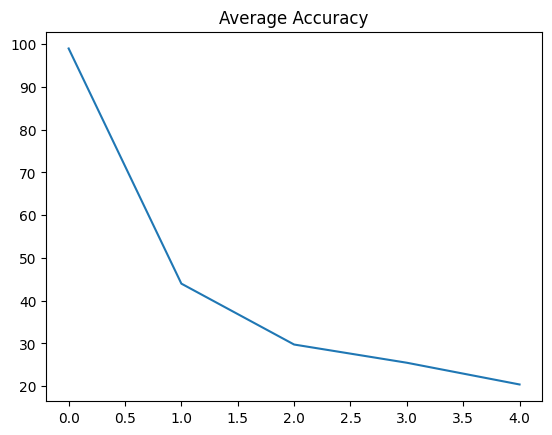

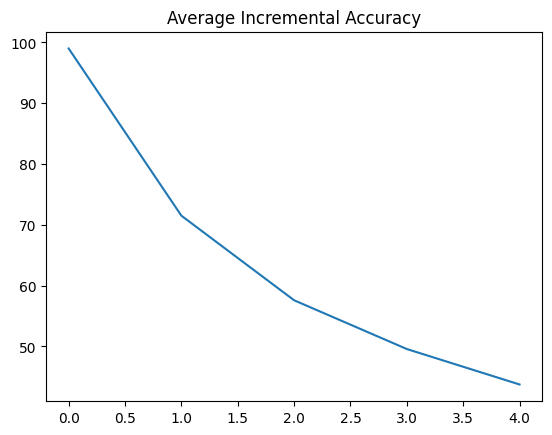

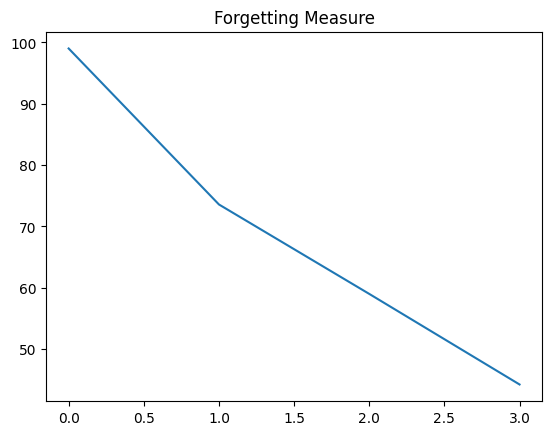

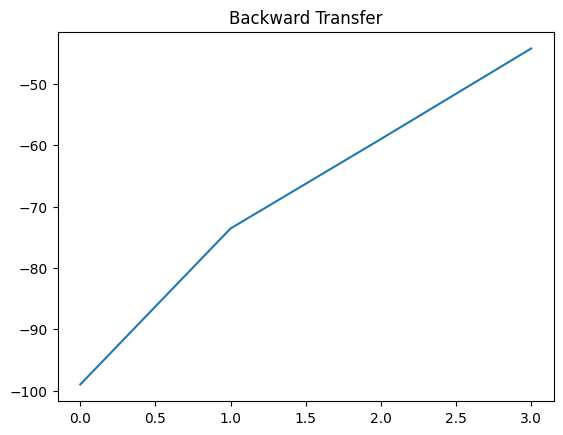

<Figure size 640x480 with 0 Axes>

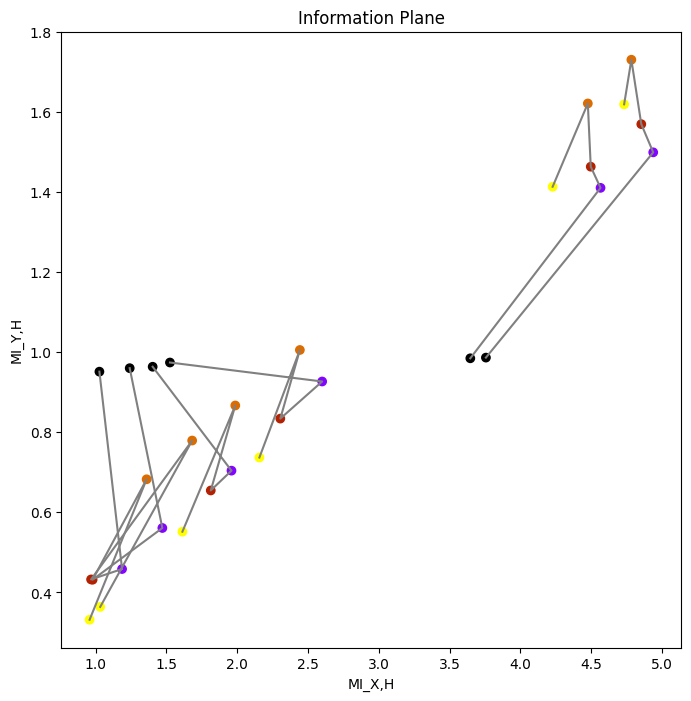

In [ ]:
#@title Plot Results
plt.figure()
plt.title("Average Accuracy")
plt.plot(ave_accuracy)

plt.figure()
plt.title("Average Incremental Accuracy")
plt.plot(ave_inc_accuracy)

plt.figure()
plt.title("Forgetting Measure")
plt.plot(forgetting_measure)

plt.figure()
plt.title("Backward Transfer")
plt.plot(backward_transfer)

plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('MI_X,H')
ax.set_ylabel('MI_Y,H')
title = ax.set_title('Information Plane')
cmap = plt.get_cmap('gnuplot', len(tasks))
colors = [cmap(i) for i in np.linspace(0, 1, len(tasks))]
ax.plot(MI_XH, MI_YH, '-', color='gray')
for layer in range(layers):
    im = ax.scatter(MI_XH[:,layer], MI_YH[:,layer], c=colors)